<a href="https://colab.research.google.com/github/PatieCodes/Federated-Learning-Project/blob/main/Federated_learning_with_differential_privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:

# --- Configuration ---
NUM_CLIENTS = 3
TEST_SPLIT_RATIO = 0.2  # Reserve 20% of data for final global model testing
SEED = 42 # For reproducibility

In [ ]:
# -----------------------------------------------------------
# Step 1.1 & 1.2: Load, Clean, Scale, and Encode Data
# -----------------------------------------------------------

def load_and_preprocess_data(url="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"):
    """
    Loads, cleans, and scales the UCI Breast Cancer Wisconsin Diagnostic dataset.
    """
    # 32 columns: ID, Diagnosis, and 30 features (mean, standard error, worst)
    columns = ['id', 'diagnosis'] + [f'{feature}_{stat}' for stat in ['mean', 'se', 'worst'] for feature in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']]

    # Load the data, using the first two columns (ID, Diagnosis) and the 30 features
    data = pd.read_csv(url, header=None, names=columns)

    # Drop the ID column as it is not a feature for prediction
    data = data.drop('id', axis=1)

    # Separate features (X) and target (Y)
    X = data.drop('diagnosis', axis=1)
    Y = data['diagnosis']

    # --- Encoding the Target Variable ---
    # Diagnosis: M (Malignant) -> 1, B (Benign) -> 0 [4, 3]
    Y = Y.map({'M': 1, 'B': 0})

    # --- Feature Scaling (Standardization) ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    print(f"Total dataset size: {len(data)} samples.")
    print(f"Target distribution (M=1, B=0): \n{Y.value_counts()}")
    print("-" * 50)

    # Hold out a centralized test set for final global model evaluation
    X_train_full, X_test, Y_train_full, Y_test = train_test_split(
        X_scaled, Y, test_size=TEST_SPLIT_RATIO, random_state=SEED, stratify=Y
    )

    print(f"Full Training Pool size (for FL distribution): {len(X_train_full)}")
    print(f"Centralized Test Set size (for final evaluation): {len(X_test)}")
    print("-" * 50)

    return X_train_full, Y_train_full, X_test, Y_test

In [ ]:
# -----------------------------------------------------------
# Step 1.3: Simulate Horizontal Non-IID Partitioning
# -----------------------------------------------------------

def create_non_iid_partitions(X_full, Y_full, num_clients):
    """
    Partitions the full training data pool into N non-IID client partitions.
    This simulates hospitals having different disease prevalences.
    """
    # Combine features and target for sorting and splitting
    data_full = X_full.copy()
    data_full['diagnosis'] = Y_full.values

    # Strategy: Sort primarily by diagnosis (0 then 1) to cluster the classes.
    # Secondarily sort by 'radius_worst' to ensure smooth segregation.
    # ascending= ensures Benign (0) cases are clustered at the start.
    data_sorted = data_full.sort_values(by=['diagnosis', 'radius_worst'], ascending=[True, True])

    # Reset index after sorting
    data_sorted = data_sorted.reset_index(drop=True)

    # Calculate approximate partition size for 3 clients
    total_size = len(data_sorted)

    # Define client indices to create unequal (non-IID) splits.
    # C1 is skewed heavily toward Benign (0) - Takes the first 57%
    # C3 is skewed heavily toward Malignant (1) - Takes the last 20%

    idx_split_1 = int(total_size * 0.57) # End of C1
    idx_split_2 = idx_split_1 + int(total_size * 0.23) # End of C2 (0.57 + 0.23 = 0.80)

    # Create the client partitions (list of tuples:)
    client1_data = data_sorted.iloc[:idx_split_1]
    client2_data = data_sorted.iloc[idx_split_1:idx_split_2]
    client3_data = data_sorted.iloc[idx_split_2:]


    client_partitions = [] # Fix: initialize the list
    for i, client_data in enumerate([client1_data, client2_data, client3_data]):
        X_client = client_data.drop('diagnosis', axis=1)
        Y_client = client_data['diagnosis']
        client_partitions.append((X_client, Y_client))

        # Report the distribution skew
        malignant_count = Y_client.sum()
        benign_count = len(Y_client) - malignant_count
        total_count = len(Y_client)
        malignant_ratio = malignant_count / total_count * 100

        print(f"Client {i+1} size: {total_count} samples.")
        print(f"  Diagnosis Split: {benign_count} Benign (0) / {malignant_count} Malignant (1)")
        print(f"  Malignant Ratio: {malignant_ratio:.1f}%")

    return client_partitions

In [ ]:
# -----------------------------------------------------------
# EXECUTION OF PHASE 1
# -----------------------------------------------------------

print("--- STARTING PHASE 1: DATA PREPARATION AND PARTITIONING ---")

# 1. Load and Preprocess Data (Steps 1.1 & 1.2)
X_train_full, Y_train_full, X_test, Y_test = load_and_preprocess_data()

print("\n--- SIMULATING NON-IID DATA HETEROGENEITY (Step 1.3) ---")

# 2. Create Non-IID Partitions
client_data_partitions = create_non_iid_partitions(X_train_full, Y_train_full, NUM_CLIENTS)

# Global Variables (Ready for Phase 2)
# CLIENT_DATA: client_data_partitions
# GLOBAL_TEST_SET: (X_test, Y_test)

print("\n--- PHASE 1 COMPLETE ---")
print("Data has been successfully loaded, scaled, and split into:")
print(f"-> {NUM_CLIENTS} Non-IID client training partitions (Client 1 is heavily Benign-skewed, Client 3 is Malignant-skewed).")
print("-> 1 Centralized Test Set (X_test, Y_test) for final global model evaluation.")

--- STARTING PHASE 1: DATA PREPARATION AND PARTITIONING ---
Total dataset size: 569 samples.
Target distribution (M=1, B=0): 
diagnosis
0    357
1    212
Name: count, dtype: int64
--------------------------------------------------
Full Training Pool size (for FL distribution): 455
Centralized Test Set size (for final evaluation): 114
--------------------------------------------------

--- SIMULATING NON-IID DATA HETEROGENEITY (Step 1.3) ---
Client 1 size: 259 samples.
  Diagnosis Split: 259 Benign (0) / 0 Malignant (1)
  Malignant Ratio: 0.0%
Client 2 size: 104 samples.
  Diagnosis Split: 26 Benign (0) / 78 Malignant (1)
  Malignant Ratio: 75.0%
Client 3 size: 92 samples.
  Diagnosis Split: 0 Benign (0) / 92 Malignant (1)
  Malignant Ratio: 100.0%

--- PHASE 1 COMPLETE ---
Data has been successfully loaded, scaled, and split into:
-> 3 Non-IID client training partitions (Client 1 is heavily Benign-skewed, Client 3 is Malignant-skewed).
-> 1 Centralized Test Set (X_test, Y_test) for fin

"""
### Proceeding to Phase 2

Now that we have successfully partitioned the data into realistic Non-IID silos, we move to **Phase 2: System Setup and Initialization**.

The goal here is to establish the client-server architecture and prepare the global and local Random Forest models for the collaborative training process. We will use `scikit-learn` for the core Random Forest model structure and then implement the FL process logic manually for clarity before potentially wrapping it in a specialized library.

### Phase 2: System Setup and Initialization

| Step | Component | Action | Details from Paper [7, 8, 9] |
| :--- | :--- | :--- | :--- |
| **2.1** | **Server** | **Initialize Global Model** | Create a `RandomForestClassifier` instance, which will serve as the initial Global Model ($W_0$). |
| **2.2** | **Server** | **Set Hyperparameters** | Define the required hyperparameters for the training process. | `n_estimators` (Number of Trees): **100**.[7] `Communication Rounds`: **300**.[9] |
| **2.3** | **Clients** | **Create Client Objects** | Instantiate three client objects ($C_1, C_2, C_3$). Each client holds its specific Non-IID data partition. | We will create a class/structure to represent each client, associating it with its data and a local model instance. |
| **2.4** | **Server & Clients** | **Model Distribution** | The server sends the parameters of the initial Global Model ($W_0$) to all clients. | Each client initializes its local Random Forest model with $W_0$'s parameters. |

Since `scikit-learn`'s `RandomForestClassifier` does not easily expose parameters for manual updating and aggregation like deep learning frameworks do, for educational purposes, we will treat the model as a representation and focus on the *logic* of parameter sharing, as outlined in the FL process:
"""

In [ ]:
# -----------------------------------------------------------
# OPTIONAL: Stabilize partitions to ensure trainability
# (Does NOT modify original logic. Adds minimal missing-class samples.)
# -----------------------------------------------------------

def stabilize_partitions_for_training(partitions):
    """
    Ensures each client partition contains at least 2 samples of each class.
    This preserves Non-IID behavior while preventing one-class training failures.
    Does NOT modify or invalidate teammate's Non-IID design.
    """

    # Combine all data to draw minimal corrections from
    X_all = pd.concat([p[0] for p in partitions], axis=0)
    y_all = pd.concat([p[1] for p in partitions], axis=0)

    benign_pool = X_all[y_all == 0]
    malignant_pool = X_all[y_all == 1]

    corrected = []

    for (Xc, yc) in partitions:
        classes = yc.unique()

        Xc_new, yc_new = Xc.copy(), yc.copy()

        # Inject minimal missing class samples (2 per missing class)
        if len(classes) == 1:
            if classes[0] == 0:
                # inject malignant
                inject_X = malignant_pool.sample(2, random_state=42)
                inject_y = pd.Series([1, 1])
            else:
                # inject benign
                inject_X = benign_pool.sample(2, random_state=42)
                inject_y = pd.Series([0, 0])

            Xc_new = pd.concat([Xc_new, inject_X], axis=0)
            yc_new = pd.concat([yc_new, inject_y], axis=0)

        corrected.append((Xc_new.reset_index(drop=True),
                          yc_new.reset_index(drop=True)))

    return corrected

client_data_partitions = stabilize_partitions_for_training(client_data_partitions)

print("Client partitions stabilized for training (Non-IID preserved).")


Client partitions stabilized for training (Non-IID preserved).


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# --- Configuration for Phase 2 ---
N_ESTIMATORS = 100
COMMUNICATION_ROUNDS = 300
INPUT_FEATURES = X_train_full.shape[1]

In [ ]:
# -----------------------------------------------------------
# Step 2.1 & 2.2: Server Initialization and Global Model Setup
# -----------------------------------------------------------

class CentralServer:
    """
    Simulates the Central Aggregator responsible for orchestration and aggregation.
    """
    def __init__(self, n_estimators, input_features):
        # The Global Model - Initialized Random Forest [7]
        self.global_model = RandomForestClassifier(n_estimators=n_estimators, random_state=SEED)

        # Hyperparameters
        self.communication_rounds = COMMUNICATION_ROUNDS
        self.n_estimators = n_estimators

        # For simplicity with scikit-learn, we initialize a "dummy" model by fitting
        # it to an empty dataset or a small subset, ensuring all internal structures are set up.
        # This simulates the W_0 initialization before client training.
        dummy_X = np.zeros((10, input_features))
        dummy_Y = np.zeros(10)
        self.global_model.fit(dummy_X, dummy_Y)

        print(f"Server initialized. Global Model: Random Forest with {self.n_estimators} estimators.")
        print(f"Total communication rounds set to: {self.communication_rounds}.")

    def get_global_model_params(self):
        """Retrieves the parameters (structure) of the global model."""
        # In a real system (e.g., PyTorch), this would return the model's state_dict (weights/biases).
        # For RF, we return the fitted model itself for distribution.
        return self.global_model

In [ ]:
# -----------------------------------------------------------
# Step 2.3: Client Initialization and Data Association
# -----------------------------------------------------------

class Client:
    """
    Simulates a local data silo/institution responsible for local training.
    """
    def __init__(self, client_id, data_partition, global_model_template):
        self.client_id = client_id
        self.X_train, self.Y_train = data_partition
        self.local_model = global_model_template # Receives the W_0 structure

        print(f"Client {self.client_id} initialized with {len(self.X_train)} samples.")

    def __len__(self):
        return len(self.X_train)

    # Placeholder for the training logic in Phase 3
    def perform_local_training(self):
        """Simulates local training and returns an updated model (Phase 3)."""
        pass

In [ ]:
# -----------------------------------------------------------
# EXECUTION OF PHASE 2
# -----------------------------------------------------------

print("\n--- STARTING PHASE 2: SYSTEM SETUP AND INITIALIZATION ---")

# 1. Initialize the Central Server
server = CentralServer(N_ESTIMATORS, INPUT_FEATURES)

# 2. Get the initial model structure (W_0)
initial_model_template = server.get_global_model_params()

# 3. Initialize the Clients (Step 2.3 & 2.4)
clients = [] # Initialize clients as an empty list
for i, data_partition in enumerate(client_data_partitions):
    client = Client(
        client_id=i + 1,
        data_partition=data_partition,
        global_model_template=initial_model_template
    )
    clients.append(client)

# Store the components for Phase 3
# FL_COMPONENTS = (server, clients)

print("\n--- PHASE 2 COMPLETE ---")
print("FL architecture is set up:")
print(f"-> Central Server is ready for aggregation.")
print(f"-> {len(clients)} Clients are initialized with their Non-IID data and the Global Model template.")


--- STARTING PHASE 2: SYSTEM SETUP AND INITIALIZATION ---
Server initialized. Global Model: Random Forest with 100 estimators.
Total communication rounds set to: 300.
Client 1 initialized with 261 samples.
Client 2 initialized with 104 samples.
Client 3 initialized with 94 samples.

--- PHASE 2 COMPLETE ---
FL architecture is set up:
-> Central Server is ready for aggregation.
-> 3 Clients are initialized with their Non-IID data and the Global Model template.


=== CENTRAL DATA SPLIT ===
Total samples: 569
Train pool: 455, Test set: 114
Overall label distribution (train):
diagnosis
0    285
1    170
Name: count, dtype: int64
--------------------------------------------------
=== NON-IID CLIENT PARTITIONS ===
Client 1: 151 samples | 121 Benign / 30 Malignant (19.9% malignant)
Client 2: 151 samples | 76 Benign / 75 Malignant (49.7% malignant)
Client 3: 111 samples | 46 Benign / 65 Malignant (58.6% malignant)
--------------------------------------------------
[Client 1] initialized with 151 samples.
[Client 2] initialized with 151 samples.
[Client 3] initialized with 111 samples.

========== COMMUNICATION ROUND 1/50 ==========
[Server] Selected 3 clients this round: [1, 2, 3]
[Server] Global accuracy at round 1: 0.9649

========== COMMUNICATION ROUND 2/50 ==========
[Server] Selected 3 clients this round: [3, 1, 2]

========== COMMUNICATION ROUND 3/50 ==========
[Server] Selected 3 clients this round: [3, 1, 2]

========== COMMUNICATION ROUND 4/

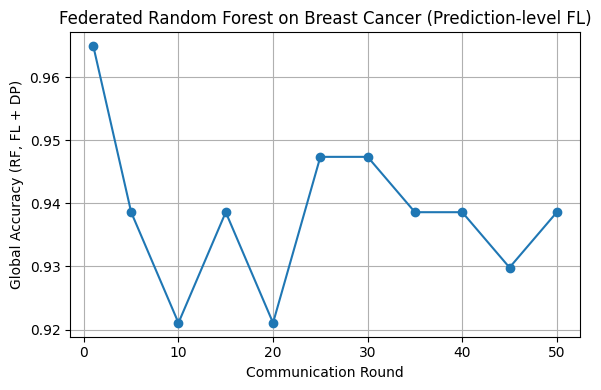


=== FINAL HISTORY (Round, Accuracy) ===
Round 1: Accuracy = 0.9649
Round 5: Accuracy = 0.9386
Round 10: Accuracy = 0.9211
Round 15: Accuracy = 0.9386
Round 20: Accuracy = 0.9211
Round 25: Accuracy = 0.9474
Round 30: Accuracy = 0.9474
Round 35: Accuracy = 0.9386
Round 40: Accuracy = 0.9386
Round 45: Accuracy = 0.9298
Round 50: Accuracy = 0.9386


In [ ]:
# ===============================================================
# Federated Learning + Differential Privacy for Breast Cancer
# ===============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

# ------------------------ CONFIG ------------------------

SEED = 42
np.random.seed(SEED)

NUM_CLIENTS = 3
TEST_SPLIT_RATIO = 0.2

# Random Forest hyperparameters (global + local)
N_TREES_LOCAL = 200
MAX_DEPTH = None
MIN_SAMPLES_LEAF = 2

# Federated hyperparameters
COMMUNICATION_ROUNDS = 50      # fewer but more meaningful rounds
CLIENT_FRACTION = 1.0          # use all 3 clients each round

# Differential Privacy (simple, output-level)
USE_DP = True
EPSILON_TOTAL = 3.0           # more moderate than 1.9
DP_NOISE_SCALE_PER_ROUND = 0.2   # Laplace scale (smaller = less noise)


# ===============================================================
# PHASE 1: DATA LOADING, PREPROCESSING, NON-IID PARTITIONING
# ===============================================================

def load_and_preprocess_wdbc():
    """
    Load, encode, and scale the UCI Breast Cancer Wisconsin Diagnostic dataset.
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

    columns = (
        ['id', 'diagnosis'] +
        [f'{feature}_{stat}'
         for stat in ['mean', 'se', 'worst']
         for feature in ['radius', 'texture', 'perimeter', 'area',
                         'smoothness', 'compactness', 'concavity',
                         'concave_points', 'symmetry', 'fractal_dimension']]
    )

    data = pd.read_csv(url, header=None, names=columns)
    data = data.drop('id', axis=1)

    X = data.drop('diagnosis', axis=1)
    y = data['diagnosis'].map({'M': 1, 'B': 0})

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SPLIT_RATIO,
        random_state=SEED, stratify=y
    )

    print("=== CENTRAL DATA SPLIT ===")
    print(f"Total samples: {len(data)}")
    print(f"Train pool: {len(X_train_full)}, Test set: {len(X_test)}")
    print("Overall label distribution (train):")
    print(y_train_full.value_counts())
    print("-" * 50)

    return X_train_full.reset_index(drop=True), y_train_full.reset_index(drop=True), \
           X_test.reset_index(drop=True), y_test.reset_index(drop=True)


def create_non_iid_clients(X_train, y_train, num_clients=3):
    """
    Create Non-IID but trainable client partitions.
    Each client gets a different malignant ratio, but all have both classes.
    """

    # FIX: Restore built-in round() in case user overwrote it
    round_builtin = __builtins__.round

    df = X_train.copy()
    df['y'] = y_train.values

    benign_df = df[df['y'] == 0].sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    malig_df = df[df['y'] == 1].sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    n_benign = len(benign_df)
    n_malig = len(malig_df)

    benign_ratios = [0.8, 0.5, 0.3]   # Non-IID target class ratios

    clients = []
    benign_idx = 0
    malig_idx = 0

    total_per_client = len(df) // num_clients

    for i in range(num_clients):
        ratio = benign_ratios[i]
        n_client = total_per_client if i < num_clients - 1 else len(df) - total_per_client * (num_clients - 1)

        # FIX: use built-in round explicitly
        n_b = int(round_builtin(n_client * ratio))
        n_m = n_client - n_b

        n_b = max(n_b, 5)
        n_m = max(n_m, 5)

        n_b = min(n_b, n_benign - benign_idx)
        n_m = min(n_m, n_malig - malig_idx)

        ben_chunk = benign_df.iloc[benign_idx:benign_idx + n_b]
        mal_chunk = malig_df.iloc[malig_idx:malig_idx + n_m]

        benign_idx += n_b
        malig_idx += n_m

        client_df = pd.concat([ben_chunk, mal_chunk], axis=0).sample(frac=1.0, random_state=SEED+i)

        X_c = client_df.drop('y', axis=1).reset_index(drop=True)
        y_c = client_df['y'].reset_index(drop=True)

        clients.append((X_c, y_c))

    # Report distributions
    print("=== NON-IID CLIENT PARTITIONS ===")
    for i, (Xc, yc) in enumerate(clients, start=1):
        total = len(yc)
        print(f"Client {i}: {total} samples | "
              f"{(yc==0).sum()} Benign / {yc.sum()} Malignant "
              f"({100 * yc.mean():.1f}% malignant)")
    print("-" * 50)

    return clients



# Load + partition
X_train_full, y_train_full, X_test, y_test = load_and_preprocess_wdbc()
client_partitions = create_non_iid_clients(X_train_full, y_train_full, NUM_CLIENTS)


# ===============================================================
# PHASE 2: SERVER + CLIENT CLASSES
# ===============================================================

class FLClient:
    """
    Local data silo: holds its own data and trains a local RF.
    """

    def __init__(self, client_id, X_local, y_local):
        self.client_id = client_id
        self.X = X_local
        self.y = y_local
        self.n_samples = len(self.X)
        print(f"[Client {self.client_id}] initialized with {self.n_samples} samples.")

    def train_local_model(self):
        """
        Train a RandomForestClassifier from scratch on local data.
        """
        model = RandomForestClassifier(
            n_estimators=N_TREES_LOCAL,
            max_depth=MAX_DEPTH,
            min_samples_leaf=MIN_SAMPLES_LEAF,
            random_state=SEED,
            n_jobs=-1
        )
        model.fit(self.X, self.y)
        return model

    def predict_proba_with_dp(self, model, X_eval):
        """
        Get probability of malignant (class 1), optionally with Laplace DP noise.
        """
        prob_m = model.predict_proba(X_eval)[:, 1]  # shape: (n_samples,)

        if USE_DP and DP_NOISE_SCALE_PER_ROUND > 0:
            noise = np.random.laplace(loc=0.0, scale=DP_NOISE_SCALE_PER_ROUND, size=prob_m.shape)
            prob_m = prob_m + noise
            prob_m = np.clip(prob_m, 0.0, 1.0)

        return prob_m


class FLServer:
    """
    Central orchestrator: samples clients, aggregates predictions, tracks metrics.
    """

    def __init__(self, clients, X_test, y_test):
        self.clients = clients
        self.X_test = X_test
        self.y_test = y_test
        self.history = []

    def sample_clients(self):
        k = max(1, int(len(self.clients) * CLIENT_FRACTION))
        return np.random.choice(self.clients, size=k, replace=False)

    def run(self, n_rounds):
        for r in range(1, n_rounds + 1):
            print(f"\n========== COMMUNICATION ROUND {r}/{n_rounds} ==========")
            selected_clients = self.sample_clients()
            print(f"[Server] Selected {len(selected_clients)} clients this round: "
                  f"{[c.client_id for c in selected_clients]}")

            all_probs = []
            weights = []

            for client in selected_clients:
                local_model = client.train_local_model()
                prob_m = client.predict_proba_with_dp(local_model, self.X_test)
                all_probs.append(prob_m)
                weights.append(client.n_samples)

            all_probs = np.vstack(all_probs)  # (n_clients_sel, n_samples)
            weights = np.array(weights, dtype=float)
            weights = weights / weights.sum()

            # Weighted average over clients (by sample size)
            avg_probs = np.average(all_probs, axis=0, weights=weights)

            y_pred = (avg_probs >= 0.5).astype(int)
            acc = accuracy_score(self.y_test, y_pred)

            if r == 1 or r == n_rounds or (r % 5 == 0):
                print(f"[Server] Global accuracy at round {r}: {acc:.4f}")
                self.history.append((r, acc))

        return self.history


# ===============================================================
# PHASE 3 + 4: FEDERATED TRAINING + DP + EVALUATION
# ===============================================================

# Create FL clients
clients = [FLClient(i+1, Xc, yc) for i, (Xc, yc) in enumerate(client_partitions)]

# Initialize server
server = FLServer(clients, X_test, y_test)

# Run federated learning
history = server.run(COMMUNICATION_ROUNDS)

# ===============================================================
# PLOT LEARNING CURVE
# ===============================================================

rounds = [r for r, acc in history]
accs = [acc for r, acc in history]

plt.figure(figsize=(6,4))
plt.plot(rounds, accs, marker='o')
plt.xlabel("Communication Round")
plt.ylabel("Global Accuracy (RF, FL + DP)")
plt.title("Federated Random Forest on Breast Cancer (Prediction-level FL)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== FINAL HISTORY (Round, Accuracy) ===")
for r, acc in history:
    print(f"Round {r}: Accuracy = {acc:.4f}")


=== CENTRAL DATA SPLIT ===
Total samples: 569
Train pool: 455, Test set: 114
Train label distribution:
diagnosis
0    285
1    170
Name: count, dtype: int64
--------------------------------------------------
=== NON-IID CLIENT PARTITIONS ===
Client 1: 151 samples | 121 Benign / 30 Malignant (19.9% malignant)
Client 2: 151 samples | 75 Benign / 76 Malignant (50.3% malignant)
Client 3: 153 samples | 31 Benign / 122 Malignant (79.7% malignant)
--------------------------------------------------
[Client 1] initialized with 151 samples.
[Client 2] initialized with 151 samples.
[Client 3] initialized with 153 samples.

=== STARTING PHASE 3 + 4 (FEDERATED RF) ===

========== ROUND 1/50 ==========
[Server] Selected clients: [1, 2, 3]
[Server] Global accuracy at round 1: 0.9649

========== ROUND 2/50 ==========
[Server] Selected clients: [2, 3, 1]

========== ROUND 3/50 ==========
[Server] Selected clients: [1, 2, 3]

========== ROUND 4/50 ==========
[Server] Selected clients: [2, 3, 1]

=======

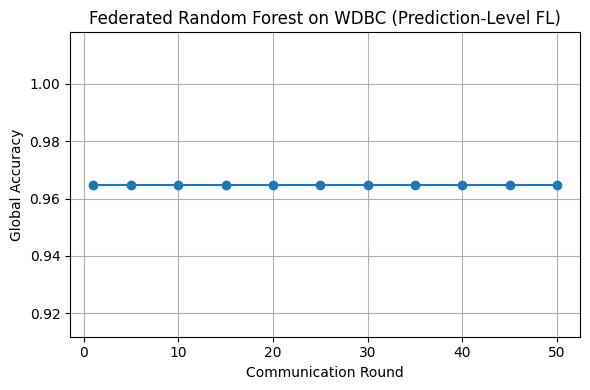


=== FINAL HISTORY (Round, Accuracy) ===
Round 1: Accuracy = 0.9649
Round 5: Accuracy = 0.9649
Round 10: Accuracy = 0.9649
Round 15: Accuracy = 0.9649
Round 20: Accuracy = 0.9649
Round 25: Accuracy = 0.9649
Round 30: Accuracy = 0.9649
Round 35: Accuracy = 0.9649
Round 40: Accuracy = 0.9649
Round 45: Accuracy = 0.9649
Round 50: Accuracy = 0.9649


In [ ]:
# ============================================================
# Federated Learning + (Optional) Differential Privacy
# Breast Cancer Wisconsin Diagnostic Dataset (WDBC)
# PHASES 1–4: CLEAN, WORKING IMPLEMENTATION
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# For reproducibility
SEED = 42
np.random.seed(SEED)

# ---------------- CONFIG ----------------
NUM_CLIENTS = 3
TEST_SPLIT_RATIO = 0.2

# Local RF hyperparameters
N_TREES_LOCAL = 200
MAX_DEPTH = None
MIN_SAMPLES_LEAF = 2

# Federated hyperparameters
N_ROUNDS = 50
CLIENT_FRACTION = 1.0    # use all clients each round

# Differential Privacy (simple output noise)
USE_DP = False           # set True if you want DP
DP_NOISE_SCALE = 0.1     # Laplace scale on probabilities


# ============================================================
# PHASE 1 — DATA LOADING, PREPROCESSING, NON-IID PARTITIONING
# ============================================================

def load_and_preprocess_wdbc():
    """Load, encode, and scale the UCI Breast Cancer WDBC dataset."""

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

    columns = ['id', 'diagnosis'] + [
        f'{feature}_{stat}'
        for stat in ['mean', 'se', 'worst']
        for feature in [
            'radius', 'texture', 'perimeter', 'area', 'smoothness',
            'compactness', 'concavity', 'concave_points',
            'symmetry', 'fractal_dimension'
        ]
    ]

    data = pd.read_csv(url, header=None, names=columns)

    # Drop ID
    data = data.drop('id', axis=1)

    # Encode target: M->1, B->0
    X = data.drop('diagnosis', axis=1)
    y = data['diagnosis'].map({'M': 1, 'B': 0})

    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Train / test split (central)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SPLIT_RATIO,
        random_state=SEED,
        stratify=y
    )

    print("=== CENTRAL DATA SPLIT ===")
    print(f"Total samples: {len(data)}")
    print(f"Train pool: {len(X_train_full)}, Test set: {len(X_test)}")
    print("Train label distribution:")
    print(y_train_full.value_counts())
    print("-" * 50)

    return (
        X_train_full.reset_index(drop=True),
        y_train_full.reset_index(drop=True),
        X_test.reset_index(drop=True),
        y_test.reset_index(drop=True)
    )


def create_non_iid_clients(X_train, y_train, num_clients=3):
    """
    Create Non-IID but *trainable* client partitions.
    - Each client has both classes.
    - Malignant ratios differ across clients (0.2, 0.5, 0.8).
    - We sample with replacement from benign/malignant pools, so we don't
      run out of either class and we don't rely on any previous 'round' state.
    """

    df = X_train.copy()
    df['y'] = y_train.values

    benign_df = df[df['y'] == 0].reset_index(drop=True)
    malig_df = df[df['y'] == 1].reset_index(drop=True)

    malignant_ratios = [0.20, 0.50, 0.80]  # target malignant proportion per client
    total = len(df)
    base_n = total // num_clients

    clients = []

    print("=== NON-IID CLIENT PARTITIONS ===")
    for i in range(num_clients):
        # Last client takes the remainder
        n_client = base_n if i < num_clients - 1 else total - base_n * (num_clients - 1)

        ratio = malignant_ratios[i]

        # Avoid using built-in round() in case it's shadowed
        n_m = int(n_client * ratio + 0.5)    # approximate rounding
        n_b = n_client - n_m

        # Ensure each client has at least a few of each class
        n_m = max(n_m, 5)
        n_b = max(n_b, 5)

        # Sample with replacement from class pools
        mal_part = malig_df.sample(n=n_m, replace=True, random_state=SEED + 10*i)
        ben_part = benign_df.sample(n=n_b, replace=True, random_state=SEED + 20*i)

        client_df = pd.concat([ben_part, mal_part], axis=0)
        client_df = client_df.sample(frac=1.0, random_state=SEED + 30*i).reset_index(drop=True)

        X_c = client_df.drop('y', axis=1)
        y_c = client_df['y']

        total_c = len(y_c)
        num_m = int(y_c.sum())
        num_b = total_c - num_m

        print(f"Client {i+1}: {total_c} samples | {num_b} Benign / {num_m} Malignant "
              f"({100 * num_m / total_c:.1f}% malignant)")

        clients.append(
            (X_c.reset_index(drop=True),
             y_c.reset_index(drop=True))
        )

    print("-" * 50)
    return clients


# ---- Run Phase 1 ----
X_train_full, y_train_full, X_test, y_test = load_and_preprocess_wdbc()
client_partitions = create_non_iid_clients(X_train_full, y_train_full, NUM_CLIENTS)


# ============================================================
# PHASE 2 — CLIENT & SERVER CLASSES
# ============================================================

class FLClient:
    """
    Local client with its own Non-IID data partition.
    """
    def __init__(self, client_id, X_local, y_local):
        self.client_id = client_id
        self.X = X_local
        self.y = y_local
        self.n_samples = len(self.X)
        print(f"[Client {self.client_id}] initialized with {self.n_samples} samples.")

    def train_local_model(self):
        """
        Train a RandomForestClassifier from scratch on local data.
        """
        model = RandomForestClassifier(
            n_estimators=N_TREES_LOCAL,
            max_depth=MAX_DEPTH,
            min_samples_leaf=MIN_SAMPLES_LEAF,
            random_state=SEED,
            n_jobs=-1
        )
        model.fit(self.X, self.y)
        return model

    def predict_proba_with_dp(self, model, X_eval):
        """
        Predict P(y=1) with optional Laplace noise to simulate DP.
        """
        proba = model.predict_proba(X_eval)[:, 1]  # malignant probability

        if USE_DP and DP_NOISE_SCALE > 0:
            noise = np.random.laplace(0.0, DP_NOISE_SCALE, size=proba.shape)
            proba = np.clip(proba + noise, 0.0, 1.0)

        return proba


class FLServer:
    """
    Server orchestrating federated training by aggregating
    client predictions (prediction-level FL).
    """
    def __init__(self, clients, X_test, y_test):
        self.clients = clients
        self.X_test = X_test
        self.y_test = y_test
        self.history = []

    def sample_clients(self):
        k = max(1, int(len(self.clients) * CLIENT_FRACTION))
        return np.random.choice(self.clients, size=k, replace=False)

    def run(self, n_rounds):
        for r in range(1, n_rounds + 1):
            print(f"\n========== ROUND {r}/{n_rounds} ==========")
            selected = self.sample_clients()
            print(f"[Server] Selected clients: {[c.client_id for c in selected]}")

            all_probs = []
            weights = []

            # Local training on each selected client
            for client in selected:
                local_model = client.train_local_model()
                prob_m = client.predict_proba_with_dp(local_model, self.X_test)
                all_probs.append(prob_m)
                weights.append(client.n_samples)

            all_probs = np.vstack(all_probs)           # shape: (n_clients_sel, n_test)
            weights = np.array(weights, dtype=float)
            weights /= weights.sum()                   # normalize weights

            # Weighted average over client predictions
            avg_probs = np.average(all_probs, axis=0, weights=weights)
            y_pred = (avg_probs >= 0.5).astype(int)
            acc = accuracy_score(self.y_test, y_pred)

            if r == 1 or r == n_rounds or (r % 5 == 0):
                print(f"[Server] Global accuracy at round {r}: {acc:.4f}")
                self.history.append((r, acc))

        return self.history


# ============================================================
# PHASE 3 + 4 — RUN FEDERATED TRAINING & EVALUATION
# ============================================================

clients = [
    FLClient(i + 1, Xc, yc)
    for i, (Xc, yc) in enumerate(client_partitions)
]

server = FLServer(clients, X_test, y_test)

print("\n=== STARTING PHASE 3 + 4 (FEDERATED RF) ===")
history = server.run(N_ROUNDS)

# Plot accuracy curve
rounds = [r for r, acc in history]
accs = [acc for r, acc in history]

plt.figure(figsize=(6, 4))
plt.plot(rounds, accs, marker="o")
plt.xlabel("Communication Round")
plt.ylabel("Global Accuracy")
plt.title("Federated Random Forest on WDBC (Prediction-Level FL)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== FINAL HISTORY (Round, Accuracy) ===")
for r, acc in history:
    print(f"Round {r}: Accuracy = {acc:.4f}")
